# Generating Data for Singapore HDB Resale Flat Prices Analysis

This notebook prepares the necessary data files for analyzing Singapore's Housing Development Board (HDB) resale flat prices. It focuses on extracting and organizing location-based information for subsequent analysis in another script.

### **CSCI323 - Group Assignment**
**Group 11**

*   Lester Liam Chong Bin (7558752)
*   Jeslyn Ho Ka Yan (8535383)
*   Bryce Nicolas Fernandez Sumcad (8561369)
*   Chea Darayuth (8550864)
*   Park Ki Sung (8379129)
*   Lee Donghyun (8876320)

<br/><hr/>

**Data Generation Steps:**

1. **Town Coordinates:** Extracts the latitude and longitude coordinates for each unique town in the HDB resale flat prices dataset using the Google Geocoding API. The results are saved in `town_lat_long.csv`.
2. **Planning Area Boundary with Town Names:** Downloads the GeoJSON file for Master Plan 2019 Planning Area Boundary (No Sea) and extracts town names from the "Description" property field, creating a new "Town" field. The updated GeoJSON file is saved as `sg-boundary-area.json`.

**Output Files:**

*   `town_lat_long.csv`: Contains the latitude and longitude coordinates for each unique town.
*   `sg-boundary-area.json`: GeoJSON file with an added "Town" field for each planning area.

These generated data files will be used for further analysis in a separate script.

## Extract Town Coordinates

In [ ]:
import pandas as pd
import requests

# Download Dataset
DATASET_ID = "d_8b84c4ee58e3cfc0ece0d773c8ca6abc"

s = requests.Session()
s.headers.update({'referer': 'https://colab.research.google.com'})
base_url = "https://api-production.data.gov.sg"
url = base_url + f"/v2/public/api/datasets/{DATASET_ID}/metadata"
print(url)
response = s.get(url)
data = response.json()['data']
columnMetadata = data.pop('columnMetadata', None)

print("Dataset Metadata:")
print(json.dumps(data, indent=2))

print("\nColumns:\n", list(columnMetadata['map'].values()))

def download_file(DATASET_ID):
  # initiate download
  initiate_download_response = s.get(
      f"https://api-open.data.gov.sg/v1/public/api/datasets/{DATASET_ID}/initiate-download",
      headers={"Content-Type":"application/json"},
      json={}
  )
  print(initiate_download_response.json()['data']['message'])

  # poll download
  MAX_POLLS = 5
  for i in range(MAX_POLLS):
    poll_download_response = s.get(
        f"https://api-open.data.gov.sg/v1/public/api/datasets/{DATASET_ID}/poll-download",
        headers={"Content-Type":"application/json"},
        json={}
    )
    print("Poll download response:", poll_download_response.json())
    if "url" in poll_download_response.json()['data']:
      print(poll_download_response.json()['data']['url'])
      DOWNLOAD_URL = poll_download_response.json()['data']['url']
      df = pd.read_csv(DOWNLOAD_URL)

      display(df.head())
      print("\nDataframe loaded!")
      return df
    if i == MAX_POLLS - 1:
      print(f"{i+1}/{MAX_POLLS}: No result found, possible error with dataset, please try again or let us know at https://go.gov.sg/datagov-supportform\n")
    else:
      print(f"{i+1}/{MAX_POLLS}: No result yet, continuing to poll\n")
    time.sleep(3)

DATASET_ID = "d_8b84c4ee58e3cfc0ece0d773c8ca6abc"
df = download_file(DATASET_ID)


https://api-production.data.gov.sg/v2/public/api/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/metadata
Dataset Metadata:
{
  "datasetId": "d_8b84c4ee58e3cfc0ece0d773c8ca6abc",
  "createdAt": "2021-07-28T10:37:00+08:00",
  "name": "Resale flat prices based on registration date from Jan-2017 onwards",
  "collectionIds": [
    "189"
  ],
  "description": "Notes:\n\n1. The approximate floor area includes any recess area purchased, space adding item under HDB\u2019s upgrading programmes, roof terrace, etc.\n\n2. The transactions exclude resale transactions that may not reflect the full market price such as resale between relatives and resale of part shares.\n\n3. Resale prices should be taken as indicative only as the resale prices agreed between buyers and sellers are dependent on many factors.",
  "format": "CSV",
  "lastUpdatedAt": "2025-04-25T02:09:50+08:00",
  "managedBy": "Housing & Development Board",
  "coverageStart": "2017-01-01T08:00:00+08:00",
  "coverageEnd": "2025-04-01T08:00:0

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0



Dataframe loaded!


In [ ]:
# Get List of Unique Towns
townList = list(pd.unique(df['town']))
print(townList)

['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN']


In [ ]:
from google.colab import userdata
import time

"""
Function that searches for a list of addresses'
latlong coordinates using Google's Geocoding API.

:townList = List of Town

Returns dict:(lat, long) of town coordinates
"""
def get_latlong(townList):

  town_latlong:dict = {}

  for t in townList:

    # Search Parameter for Google Geocoding API
    #   - Lowercase & Whitespaces Replaced with '+'
    searchParam = t.replace(' ', '+').lower()
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={searchParam}&key={userdata.get('GeolocationAPI')}"
    response = requests.get(url)
    time.sleep(3) # Wait Before Next Request

    # Response Data
    data = response.json()
    lat = data['results'][0]['geometry']['location']['lat']
    lng = data['results'][0]['geometry']['location']['lng']
    print(f"{t}: {lat}, {lng}")

    # Append to Dictionary
    town_latlong[t] = (lat, lng)

  return(town_latlong)

In [ ]:
# Get Coordinates
town_latlong = get_latlong(townList)

ANG MO KIO: 1.3691149, 103.8454342
BEDOK: 1.3236038, 103.9273405
BISHAN: 1.3525845, 103.8352116
BUKIT BATOK: 1.3590288, 103.7636796
BUKIT MERAH: 1.2819046, 103.8239182
BUKIT PANJANG: 1.3774142, 103.7719498
BUKIT TIMAH: 1.3294113, 103.8020777
CENTRAL AREA: 1.2789227, 103.8536113
CHOA CHU KANG: 1.3839803, 103.7469611
CLEMENTI: 1.3161811, 103.7649377
GEYLANG: 1.3200544, 103.8917746
HOUGANG: 1.3612182, 103.8862529
JURONG EAST: 1.3328572, 103.7435522
JURONG WEST: 1.3403898, 103.7089875
KALLANG/WHAMPOA: 1.3245132, 103.8572252
MARINE PARADE: 1.3019687, 103.8970821
PASIR RIS: 1.3720937, 103.9473728
PUNGGOL: 1.3984457, 103.9072046
QUEENSTOWN: -45.0301511, 168.6615141
SEMBAWANG: 1.4491107, 103.8184954
SENGKANG: -4.1397579, 120.030701
SERANGOON: 1.3553567, 103.8678708
TAMPINES: 1.3495907, 103.9567879
TOA PAYOH: 1.3343035, 103.8563265
WOODLANDS: 50.3577469, -3.6716796
YISHUN: 1.430368, 103.8353628


In [ ]:
# Create Pandas DataFrame
# **Note that Coordinates for [Woodlands, Sengkang, QueensTown] is Incorrect
# **and will be corrected manually after exported
data_dict = {}

data_dict['Town'] = townList
data_dict['Latitude'] = [town_latlong[t][0] for t in townList]
data_dict['Longitude'] = [town_latlong[t][1] for t in townList]

df = pd.DataFrame(data_dict)
df.head()

,Town,Latitude,Longitude
0,ANG MO KIO,1.369115,103.845434
1,BEDOK,1.323604,103.927340
2,BISHAN,1.352585,103.835212
3,BUKIT BATOK,1.359029,103.763680
4,BUKIT MERAH,1.281905,103.823918


In [ ]:
# Export to CSV
df.to_csv('town_lat_long.csv', index=False)

## GeoJSON File Creator

In [ ]:
import requests
import json
import re

# OpenAPI Request for GeoJSON File
dataset_id = "d_4765db0e87b9c86336792efe8a1f7a66"
url = "https://api-open.data.gov.sg/v1/public/api/datasets/" + dataset_id + "/poll-download"

response = requests.get(url)
json_data = response.json()
if json_data['code'] != 0:
    print(json_data['errMsg'])
    exit(1)

url = json_data['data']['url']
response = requests.get(url)
geoFile = json.loads(response.text)
print(geoFile)

{'type': 'FeatureCollection', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'Name': 'kml_1', 'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>PLN_AREA_N</th> <td>BEDOK</td> </tr><tr bgcolor=""> <th>PLN_AREA_C</th> <td>BD</td> </tr><tr bgcolor="#E3E3F3"> <th>CA_IND</th> <td>N</td> </tr><tr bgcolor=""> <th>REGION_N</th> <td>EAST REGION</td> </tr><tr bgcolor="#E3E3F3"> <th>REGION_C</th> <td>ER</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>5F00E6FF084F3364</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20191223152014</td> </tr></table></center>'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[103.932080144934, 1.3055476965106, 0.0], [103.932080154816, 1.30554765129205, 0.0], [103.932091682943, 1.30545005284135, 0.0], [103.932001693208, 1.30539389452398, 0.0], [103.931932620916, 1.30536582309684, 0.0], [103.9318570205

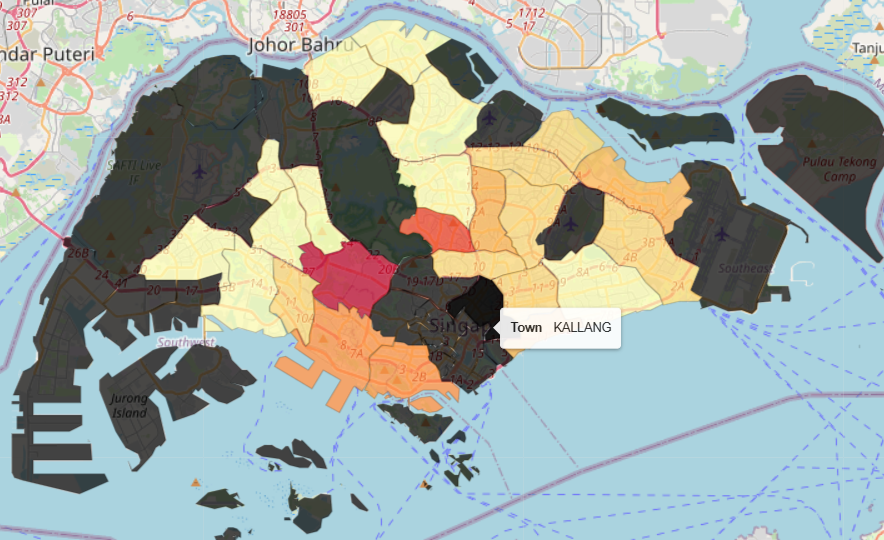

In [ ]:
# List of ASSUMED Town for CENTRAL AREA in Dataset
CENTRAL_AREA_LIST = [
    'NOVENA', 'TANGLIN', 'RIVER VALLEY',
    'NEWTON', 'SINGAPORE RIVER', 'OUTRAM',
    'DOWNTOWN CORE', 'MARINA SOUTH', 'MARINA EAST',
    'STRAITS VIEW', 'ROCHOR', 'MUSEUM',
    'ORCHARD'
]

In [ ]:
# For Each 'PLN_AREA_N' from Description & Extract Town Name
for feature in geoFile['features']:
    desc = feature['properties'].get('Description', '')
    match = re.search(r"<th>PLN_AREA_N<\/th> <td>(.*?)<\/td>", desc)
    if match:
        # Get Town Name
        townName = match.group(1).strip().upper()

        # Update Town Name
        if townName in CENTRAL_AREA_LIST:
          townName = "CENTRAL AREA"

        if townName == "KALLANG":
          townName = "KALLANG/WHAMPOA"

        feature['properties']['Town'] = townName


# Save Updated GeoJSON File
with open("sg-boundary-area.geojson", "w") as f:
    json.dump(geoFile, f)